In [2]:
import arviz as az
import numpy as np  # For vectorized math operations

# import pandas as pd  # For file input/output
import pymc as pm
import pytensor.tensor as pt
from scipy.stats import gumbel_r

from matplotlib import pyplot as plt

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [6]:
%config InlineBackend.figure_format = 'retina'  # high resolution figures
az.style.use("arviz-darkgrid")
plt.rcParams["font.family"] = "Latin Modern Roman"

rng = np.random.default_rng(42)

# Simulate some data

Data generating process is:
$$
u_{ij} = {x_i}'\beta^{\text{individual}}_{i} + {c_j}'\beta^{\text{product}}_{i} + \nu_{ij} + \varepsilon_{ij}
$$
where
- the consumer knows $\left(x_i, \beta^{\text{individual}}_i, c_j, \beta^{\text{product}}_{i}, \nu_{ij}\right)$, which implies outcome variables $\left(t_i, w_i\right)$
- the econometrician knows $\left(x_i, c_j, t_i, w_i\right)$ and has priors over $\left(\beta^{\text{individual}}, \beta^{\text{product}}\right)$
- neither the consumer nor the econometrician knows $\varepsilon_{ij}$, but they have common priors

Consumer reports
- their preferred good $j^{(1)}$
- the probability they purchase the good on a Likert scale with $W$ categories

## Notation

- $N$ is the number of individuals
- $J$ is the number of products
- $K$ is the number of product attributes
- $M$ is the number of individual attributes
- $W$ is the number of categories on the Likert scale

In [84]:
def make_data(params=None):

    ## set default parameters
    if params is None:
        params = {"N": 500, "J": 3, "K": 5, "M": 2, "W": 4}

    ## load parameters
    M = params["M"]
    W = params["W"]
    J = params["J"]
    K = params["K"]
    N = params["N"]

    np.random.seed(1234)

    ## generate latent parameters
    # individual_features = np.random.normal(0, 0.1, (N, M))
    individual_features = np.zeros((N, M))
    product_features = np.random.normal(0, 0.2, (J, K))
    π = np.random.dirichlet([1] * W, 1).flatten().cumsum()
    β_ind = np.random.normal(0, 1, M)
    β_prod = np.random.normal(0, 0.2, (K, N))
    # ν = np.random.normal(0, 1, (N, J))
    η = np.random.gumbel(0, 1, (N, J))
    # ɛ = np.random.normal(0, 1, (N, J))

    ## generate data
    # y = np.zeros((N, J))
    u_individual = np.outer(
        individual_features @ β_ind,
        np.ones(J),
    )
    u_product = (product_features @ β_prod).T
    u = (
        u_individual + u_product + η
    )  # with constant individual effects, the individual features do nothing
    t = np.argmax(u, axis=1)
    v = np.max(u, axis=1)
    w = np.digitize(gumbel_r.cdf(v), π)

    return {
        "individual_features": individual_features,
        "product_features": product_features,
        "t": t,
        "w": w,
        "latent_cutpoints": π,
        "latent_utilities": u,
    }
    #     [
    #         pd.DataFrame(individual_features, columns=[f"if_{i}" for i in range(M)]),
    #         pd.DataFrame(product_features[t], columns=[f"pf_{i}" for i in range(K)]),
    #         pd.DataFrame(t, columns=["t"]),
    #         pd.DataFrame(w, columns=["w"]),
    #     ],
    #     axis=1
    # )


df = make_data()

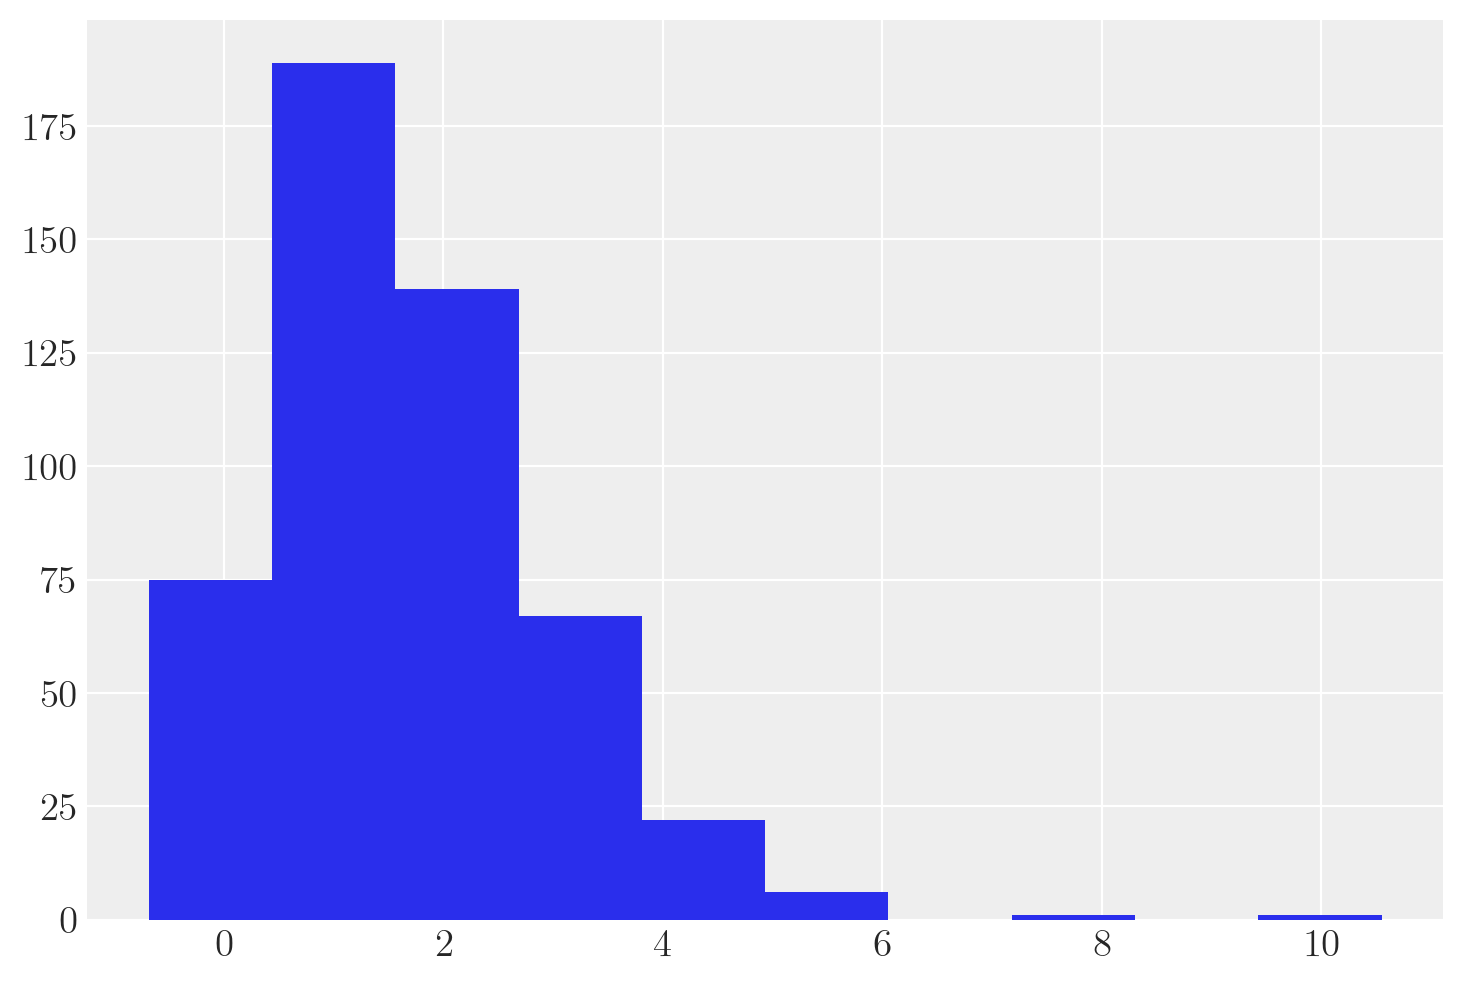

In [85]:
plt.hist(np.max(df["latent_utilities"], axis=1))
plt.show()

In [86]:
df["latent_cutpoints"]

array([0.29440327, 0.72000848, 0.81018447, 1.        ])

In [87]:
np.unique(df["w"], return_counts=True)

(array([0, 1, 2, 3]), array([ 17, 171,  76, 236]))

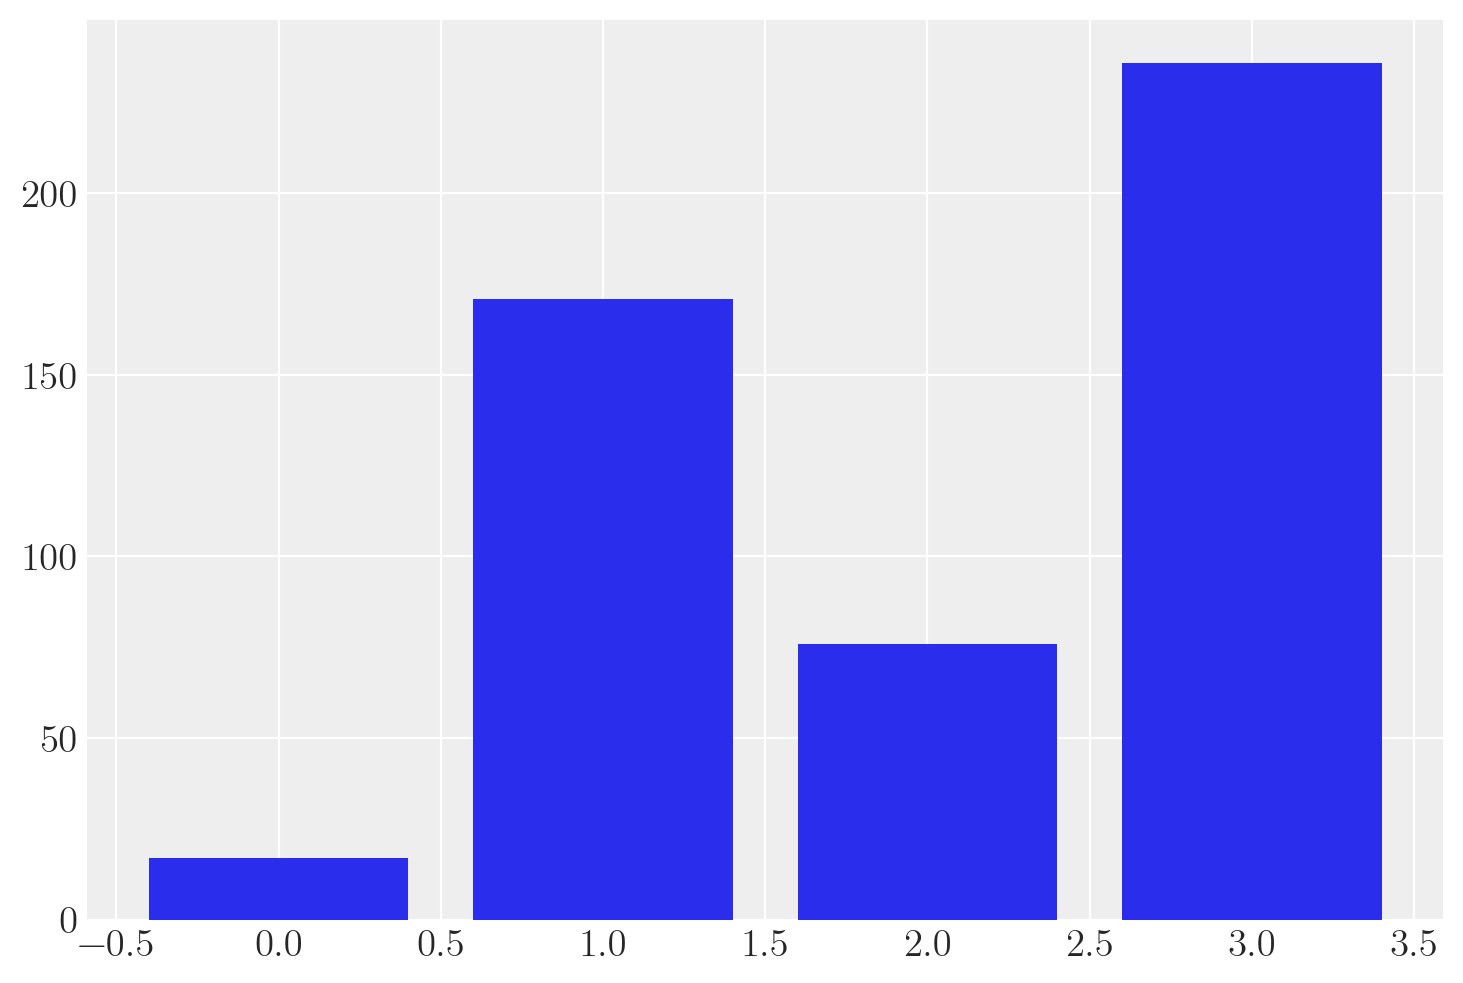

In [88]:
plt.bar(*np.unique(df["w"], return_counts=True))
plt.show()

# Estimate the Model

In [23]:
# import pytensor
# pytensor.config.compute_test_value = 'warn'

In [89]:
observed_good = df["t"]
observed_bin = df["w"]

N, M = df["individual_features"].shape
J, K = df["product_features"].shape
W = len(np.unique(observed_bin))


coords = {
    "products": [f"product_{i}" for i in range(J)],
    "i_factors": [f"if_{i}" for i in range(N)],
    "p_factors": [f"pf_{i}" for i in range(K)],
    "obs": range(N),
}

Sampling: [beta_pf, bin, latent_binwidths, mu_β_p, product, sigma_β_p]


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

/Users/gzheng/projects/professional/likert_dualresponse/.venv/lib/python3.11/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: divide by zero encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
There were 3387 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
Sampling: [bin, product]


Output()

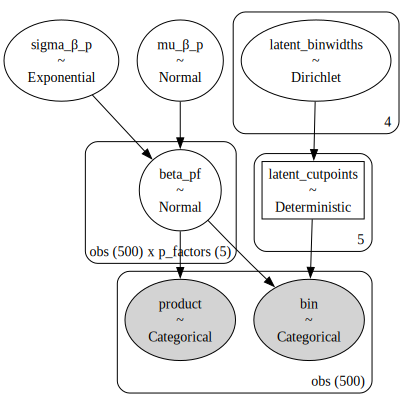

In [90]:
with pm.Model(coords=coords) as model_1:

    mu_β_p = pm.Normal("mu_β_p", 0, 1)
    sigma_β_p = pm.Exponential("sigma_β_p", 1)
    beta_p = pm.Normal(
        "beta_pf", mu_β_p, sigma_β_p, dims=["obs", "p_factors"]
    )  # want there to be N*K beta's

    π = pm.Dirichlet("latent_binwidths", a=np.ones(W))  # W x 1
    α = pm.Deterministic(
        "latent_cutpoints", pt.concatenate([np.ones(1) * 0, pt.extra_ops.cumsum(π)])
    )  # (W+1) x 1

    ## Construct Utility matrix

    s_good = pm.math.dot(beta_p, df["product_features"].T)  # N x J
    # individual_effects = pm.math.sum(pm.math.dot(beta_i, df["individual_features"]), axis=1)
    # s_person = individual_effects[:, None] * pm.math.ones_like(df["individual_features"])
    s = s_good + 0

    ## Calculate good conditional likelihoods
    p_goods = pm.math.softmax(s, axis=1)  # probability that good i is best of J

    ## Apply Gumbel-Max Adjustment
    μbar = pm.math.log(pm.math.sum(pm.math.exp(s), axis=1))  # should be N x 1

    sandwich_meat = [
        (
            pm.math.exp(pm.math.exp(μbar) * pm.math.log(α[w]))
            - pm.math.exp(pm.math.exp(μbar) * pm.math.log(α[w - 1]))
        )
        for w in range(2, W)
    ]

    ## Calculate bin conditional likelihoods
    p_bins = pt.stack(
        [
            pm.math.exp(pm.math.exp(μbar) * pm.math.log(α[1])),  # should be N x 1
            *sandwich_meat,  # should be N x W-2
            1 - pm.math.exp(pm.math.exp(μbar) * pm.math.log(α[-1])),  # should be N x 1
        ],
        axis=0,
    ).T  # should be N x W

    ## Map to observables
    good_obs = pm.Categorical("product", p=p_goods, observed=observed_good, dims="obs")
    # prob_obs = pm.Categorical("bin", p=probs, observed=observed_prob, dims="obs")
    bin_obs = pm.Categorical("bin", p=p_bins, observed=observed_bin, dims="obs")

    idata_m1 = pm.sample_prior_predictive()
    idata_m1.extend(
        pm.sample(
            nuts_sampler="numpyro",
            idata_kwargs={"log_likelihood": True},
            random_seed=100,
        )
    )
    idata_m1.extend(pm.sample_posterior_predictive(idata_m1))

pm.model_to_graphviz(model_1)

In [91]:
az.summary(idata_m1, var_names=["mu_β_p", "sigma_β_p", "latent_cutpoints"])

/Users/gzheng/projects/professional/likert_dualresponse/.venv/lib/python3.11/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: divide by zero encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/Users/gzheng/projects/professional/likert_dualresponse/.venv/lib/python3.11/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: divide by zero encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/Users/gzheng/projects/professional/likert_dualresponse/.venv/lib/python3.11/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/Users/gzheng/projects/professional/likert_dualresponse/.venv/lib/python3.11/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: divide by zero encountered in scalar divide
  (between_cha

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu_β_p,-0.010,0.433,-0.596,0.542,0.216,0.165,4.0,4.0,inf
sigma_β_p,0.897,0.440,0.455,1.431,0.219,0.168,4.0,4.0,inf
latent_cutpoints[0],0.000,0.000,0.000,0.000,0.000,0.000,4000.0,4000.0,NaN
latent_cutpoints[1],0.216,0.139,0.100,0.454,0.069,0.053,4.0,4.0,10.01
latent_cutpoints[2],0.394,0.124,0.225,0.566,0.062,0.047,4.0,4.0,20.05
latent_cutpoints[3],0.729,0.134,0.507,0.836,0.067,0.051,4.0,4.0,20.05
latent_cutpoints[4],1.000,0.000,1.000,1.000,0.000,0.000,4.0,4.0,inf
